In [23]:
from ast import literal_eval
import csv


In [24]:
from collections import namedtuple
NoduleInfoTuple = namedtuple(
    "NoduleInfoTuple",
    ["isNodule_bool", "nod_id", "center_lps", "file_path"]
)


def getNoduleInfoList():
    coord_file = "/home/kaplinsp/ct_lung_class/ct_lung_class/annots_michelle.csv"
    nodule_infos = []
    
    with open(coord_file) as f:
        reader = csv.reader(f, delimiter=",", quoting=csv.QUOTE_MINIMAL)
        next(reader)
        for row in reader:
            
            subject_id = row[2]
            try:
                coords = literal_eval(row[7])
            except SyntaxError:
                print(f"No coordinates for {subject_id}")
                continue
            file_path = f"/data/kaplinsp/prasad_d/{subject_id}.nrrd"
            nodule_infos.append(NoduleInfoTuple(1, subject_id, coords, file_path))
    
    return nodule_infos   

noduleInfo_list = getNoduleInfoList()


No coordinates for RIA_17-353D_Prasad_000_32
No coordinates for RIA_17-353D_Prasad_000_98
No coordinates for RIA_17-353D_Prasad_000_226
No coordinates for RIA_17-353D_Prasad_000_369
No coordinates for RIA_17-353D_Prasad_000_370
No coordinates for RIA_17-353D_Prasad_000_382


In [25]:
import os
import SimpleITK as sitk
import numpy as np
from util.util import XyzTuple, IrcTuple, irc2xyz, xyz2irc
import matplotlib.pyplot as plt

class CTImage:
    def __init__(self, nod_id):
        # nrrd_path = os.path.join(DATA_DIR, f"nod{nod_id}.nrrd")
        nrrd_path = os.path.join("/data/kaplinsp/prasad_d/", f"{nod_id}.nrrd")

        reader = sitk.ImageFileReader()
        reader.SetImageIO("NrrdImageIO")
        reader.SetFileName(nrrd_path)
        ct_nrrd = reader.Execute()
        self.image = ct_nrrd
        ct_a = np.array(sitk.GetArrayFromImage(ct_nrrd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
        # The upper bound nukes any weird hotspots and clamps bone down

        ct_a.clip(-1350, 150, ct_a)

        self.nod_id = nod_id
        self.hu_a = ct_a

        self.origin_xyz = XyzTuple(*ct_nrrd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_nrrd.GetSpacing())
        self.direction_a = np.array(ct_nrrd.GetDirection()).reshape(3, 3)

    def getRawNodule(self, center_xyz: XyzTuple, width_irc: IrcTuple):
        center_irc = irc2xyz(
            center_xyz,
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )
        # center_irc = center_xyz

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis] / 2))
            end_ndx = int(start_ndx + width_irc[axis])

            # print(self.nod_id)
            # assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr(
            #     [self.nod_id, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis]
            # )
            if start_ndx < 0:
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        return self.hu_a[tuple(slice_list)], center_irc
    

# def lps_to_voxel(lps_coords, image):
#     # Convert LPS coordinates to voxel coordinates
#     voxel_coords = image.TransformPhysicalPointToIndex(lps_coords)
#     return np.array(voxel_coords, dtype=int)

def extract_bounding_box(image_array, voxel_coords, box_size=200):
    z, y, x = voxel_coords  # Adjust for reversed order
    half_size = box_size // 2
    
    # Calculate the bounding box limits
    x_min = max(0, x - half_size)
    x_max = min(image_array.shape[0], x + half_size)
    y_min = max(0, y - half_size)
    y_max = min(image_array.shape[1], y + half_size)
    z_min = max(0, z - half_size)
    z_max = min(image_array.shape[2], z + half_size)
    
    # Ensure indices are integers
    x_min, x_max, y_min, y_max, z_min, z_max = map(int, [x_min, x_max, y_min, y_max, z_min, z_max])
    
    # Print bounding box limits for debugging
    print(f"Bounding box limits: z: ({z_min}, {z_max}), y: ({y_min}, {y_max}), x: ({x_min}, {x_max})")
    
    # Extract the bounding box
    bounding_box = image_array[x_min:x_max, y_min:y_max, z_min:z_max]
    
    return bounding_box

failures = []
"""THIS WORKS FOR DICOM"""
for nodule in noduleInfo_list:
    if nodule.nod_id == "RIA_17-353D_Prasad_000_233":
        # nrrd_path = os.path.join("/data/kaplinsp/prasad_d/", f"{nodule.nod_id}.nrrd")

        reader = sitk.ImageSeriesReader()
        dicom_files = reader.GetGDCMSeriesFileNames("/data/kaplinsp/prasad_d/RIA_17-353D_Prasad_000_233")
        reader.SetFileNames(dicom_files)
        image = reader.Execute()
        # reader.SetImageIO("NrrdImageIO")
        # reader.SetFileName(nrrd_path)
        # image = reader.Execute()
        # index = np.array(nodule.center_xyz)[::-1]
        center_transformed = np.array(nodule.center_xyz)
        center_transformed[0] *= - 1
        center_transformed[1] *= -1
        print(center_transformed)
        index = image.TransformPhysicalPointToIndex(center_transformed)
        
        size_x = 200  # Size in the x-direction
        size_y = 200  # Size in the y-direction
        size_z = 30  # Size in the z-direction

        # Define the bounding box limits
        start_x = int(max(0, index[0] - size_x // 2))
        end_x = int(min(image.GetWidth(), index[0] + size_x // 2))

        # index[1] = image.GetHeight() - index[1]
        start_y = int(max(0, index[1] - size_y // 2))
        end_y = int(min(image.GetHeight(), index[1] + size_y // 2))

        start_z = int(max(0, index[2] - size_z // 2))
        end_z = int(min(image.GetDepth(), index[2] + size_z // 2))

        image_array = sitk.GetArrayFromImage(image)
        sliced = image_array[slice(start_z, end_z), slice(start_y, end_y), slice(start_x, end_x)]        
        plt.imshow(sliced[15, :, :], cmap="gray")
        plt.title('X-axis slice of the bounding box region')
        plt.colorbar()
        plt.show()


    


AttributeError: 'NoduleInfoTuple' object has no attribute 'center_xyz'

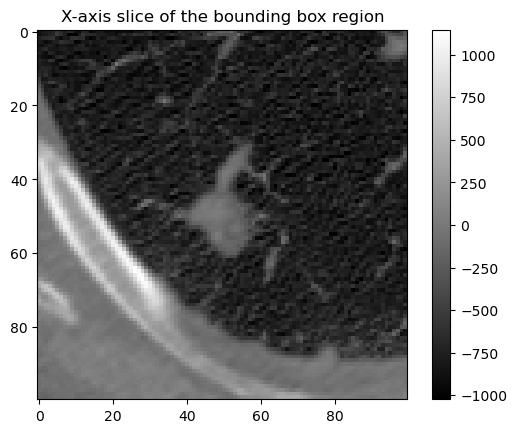

NameError: name 'NoduleInfoTuple' is not defined

In [ ]:
from functools import lru_cache
import functools
from typing import List, Optional, Tuple
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# from datasets import get_coord_csv
from lungmask import LMInferer

class NoduleImage:
    def __init__(self, nod_id: str, image_file_path: str, center_lps: np.array):
        self.nod_id = nod_id
        self.image_file_path = image_file_path
        self.center_lps = center_lps
        
    def _image(self):
        raise NotImplementedError("Subclasses must override")
        
    @property
    def image(self):
        return self._image()
    
    @functools.lru_cache(maxsize=2)
    def image_array(self, segmented: Optional[bool] = False) -> np.array:
        image_arr = sitk.GetArrayFromImage(self.image)
        if not segmented:
            return image_arr
        
        inferrer = LMInferer(tqdm_disable=True)
        mask = inferrer.apply(image_arr)
        return image_arr * mask.astype(bool)
        
    
    
    def nodule_slice(self, box_dim: Tuple[int, int, int] = (60,60,60), segmented: Optional[bool] = False) -> np.array:
        index = self.image.TransformPhysicalPointToIndex(self.center_lps)
        size_x, size_y, size_z = box_dim
        
        start_x = int(max(0, index[0] - size_x // 2))
        end_x = int(min(self.image.GetWidth(), index[0] + size_x // 2))

        start_y = int(max(0, index[1] - size_y // 2))
        end_y = int(min(self.image.GetHeight(), index[1] + size_y // 2))

        start_z = int(max(0, index[2] - size_z // 2))
        end_z = int(min(self.image.GetDepth(), index[2] + size_z // 2))

        image_array = self.image_array(segmented=segmented)
        
        return image_array[slice(start_z, end_z), slice(start_y, end_y), slice(start_x, end_x)] 
    

class NRRDNodule(NoduleImage):
    """Class for loading nodules from NRRD"""
    
    @lru_cache(maxsize=1)
    def _image(self) -> sitk.Image:
        reader = sitk.ImageFileReader()
        reader.SetImageIO("NrrdImageIO")
        reader.SetFileName(self.image_file_path)
        return reader.Execute()
    


class DICOMNodule(NoduleImage):
    """Class for loading an image of a nodule from DICOM"""
    
    @lru_cache(maxsize=1)
    def _image(self) -> sitk.Image:
        reader = sitk.ImageSeriesReader()
        dicom_files = reader.GetGDCMSeriesFileNames(self.image_file_path)
        reader.SetFileNames(dicom_files)
        image = reader.Execute()
        return image
    
    
def ras_to_lps(tup):
    tup[0] *= -1
    tup[1] *= -1
    return tup


nodule = DICOMNodule(nod_id="RIA_17-353D_Prasad_000_35", 
                        image_file_path="/home/kaplinsp/ct_lung_class/581691/scans/4-1_25/resources/DICOM/files",
                        center_lps=ras_to_lps([51.4106, -46.4581, -142.25])
)
# nodule = NRRDNodule(
#     nod_id="3",
#     image_file_path = f"/data/etay/lung_hist_dat/original_dat_nrrds/nod3.nrrd",
#     center_lps = get_coord_csv("R74","P80","I172")
# )

slice = nodule.nodule_slice(box_dim=(100,100,30), segmented=False)
plt.imshow(slice[16, :, :], cmap="gray")
plt.title('X-axis slice of the bounding box region')
plt.colorbar()
plt.show()


def load_annotation_michelle() -> List[NoduleInfoTuple]:
    coord_file = "/home/kaplinsp/ct_lung_class/ct_lung_class/annots_michelle.csv"
    nodule_infos = []
    
    with open(coord_file) as f:
        reader = csv.reader(f, delimiter=",", quoting=csv.QUOTE_MINIMAL)
        next(reader)
        for row in reader:
            
            subject_id = row[2]
            try:
                coords = literal_eval(row[7])
                coords = ras_to_lps(coords)
            except SyntaxError:
                log.warning(f"No coordinates for {subject_id}")
                continue
            nodule_infos.append(NoduleInfoTuple(1, subject_id, coords, "file_path"))
    
    return nodule_infos            

In [ ]:
coord = 100,100,30
pad_width = [(0, max(0, coord[2-i] - slice.shape[i])) for i in range(3)]
p = np.pad(slice, pad_width=pad_width, mode='constant', constant_values=0)
np.all(p == slice)

True

In [22]:
from datatsets_peter import DICOMNodule, NRRDNodule,  ras_to_lps
nodule = DICOMNodule(
                         image_file_path="/data/kaplinsp/prasad_d/RIA_17-353D_Prasad_000_35/",
                         center_lps=ras_to_lps([51.4106, -46.4581, -142.25])
)

In [23]:
import SimpleITK as sitk
nrrdnodule = NRRDNodule(image_file_path="test.nrrd", center_lps=ras_to_lps([51.4106, -46.4581, -142.25]))

In [ ]:
from datatsets_peter import *
from datasets import getCtRawNodule
infos = NoduleInfoGenerator()
infos.add_strategies(R17SampleGeneratorStrategy, PrasadSampleGeneratoryStrategy)
infos = infos.generate_all_samples()


AttributeError: module 'numpy' has no attribute 'typing'

In [19]:
# n = [n for n in infos if n.file_path == "/data/kaplinsp/prasad_d/RIA_17-353D_Prasad_000_6"][0] # 257
infos = getNoduleInfoList()
n = [n for n in infos if n.nod_id == "RIA_17-353D_Prasad_000_76"][0]
nodule = n.image_type(n.file_path, n.center_lps)

2024-07-31 19:41:25,353 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 20
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 20
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 26
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 29
2024-07-31 19:41:25,354 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 61
2024-07-31 19:41:25,355 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 69
2024-07-31 19:41:25,355 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 103
2024-07-31 19:41:25,355 INFO     pid:1802144 datatsets_peter:170:generate_nodule_info EXCLUDING: 128


IndexError: list index out of range

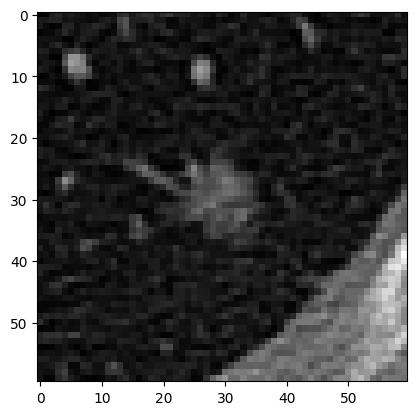

In [ ]:
import matplotlib.pyplot as plt
nod, _ = getCtRawNodule(n.file_path, n.image_type, n.center_lps, (60,60,60), False)
original, _ = nodule.nodule_slice(preprocess=False)
plt.imshow(original[30,:,:], cmap="gray")

Slice shape (60, 100, 100)


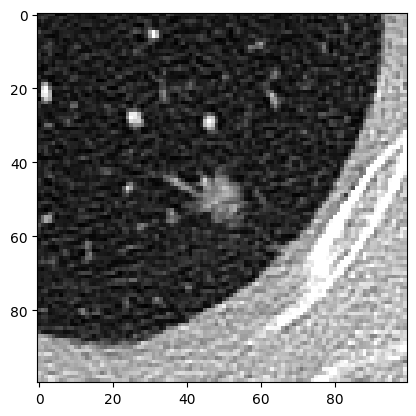

In [ ]:
print("Slice shape", sliced_arr.shape)
sliced_arr = np.clip(sliced_arr, -1400, 1400)
plt.imshow(sliced_arr[30,:,:], cmap="gray")

In [1]:
from datasets import getNoduleInfoList, slice_and_pad_segmentation, getCtRawNodule
noduleInfo_tup = getNoduleInfoList()[0]
width_irc = (40, 40, 30)
nodule_a, slice_3d = getCtRawNodule(
                noduleInfo_tup.file_path,
                noduleInfo_tup.image_type,
                noduleInfo_tup.center_lps,
                width_irc,
                preprocess=False
            )
nod_segmentation = slice_and_pad_segmentation("nodule", noduleInfo_tup, width_irc, slice_3d)

/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-01 14:33:00,555 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 20
2024-08-01 14:33:00,557 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 20
2024-08-01 14:33:00,557 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 26
2024-08-01 14:33:00,558 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 29
2024-08-01 14:33:00,559 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 61
2024-08-01 14:33:00,559 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 69
2024-08-01 14:33:00,560 INFO     pid:1963349 datatsets_peter:175:generate_nodule_info EXCLUDING: 103
2024-08-01 14:33:00,561 INFO     pid:

In [1]:
from datasets import getNoduleInfoList
nods = getNoduleInfoList()

/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-01 19:30:19,277 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 20
2024-08-01 19:30:19,277 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 20
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 26
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 29
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 61
2024-08-01 19:30:19,278 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 69
2024-08-01 19:30:19,279 INFO     pid:2177558 datatsets_peter:178:generate_nodule_info EXCLUDING: 103
2024-08-01 19:30:19,279 INFO     pid:

In [2]:
len(nods)

109

In [7]:
train = ['/data/etay/lung_hist_dat/original_dat_nrrds/nod44.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod98.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod88.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod85.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod114.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod143.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod68.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod162.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod22.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod116.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod8.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod43.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod175.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod160.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod123.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod94.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod53.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod5.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod132.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod72.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod74.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod84.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod173.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod173.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod48.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod36.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod12.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod3.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod54.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod83.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod18.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod23.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod19.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod71.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod82.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod144.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod151.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod45.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod139.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod11.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod1.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod167.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod6.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod47.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod46.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod63.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod119.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod147.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod80.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod89.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod131.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod31.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod67.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod39.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod144.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod112.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod109.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod104.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod86.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod76.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod144.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod28.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod164.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod130.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod50.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod21.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod15.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod9.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod100.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod138.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod32.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod111.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod16.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod108.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod63.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod55.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod62.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod178.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod49.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod43.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod87.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod73.nrrd']
val = ['/data/etay/lung_hist_dat/original_dat_nrrds/nod17.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod30.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod97.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod41.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod56.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod150.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod185.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod77.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod136.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod129.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod65.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod77.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod113.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod156.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod57.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod105.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod25.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod40.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod33.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod90.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod96.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod127.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod157.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod169.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod35.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod24.nrrd', '/data/etay/lung_hist_dat/original_dat_nrrds/nod42.nrrd']
train = set(train)
val = set(val)
train.intersection(val)

set()

In [7]:
import SimpleITK as sitk
import numpy as np 
import matplotlib.pyplot as plt
nodule = sitk.ReadImage("/data/etay/lung_hist_dat/original_dat_nrrds/nod100.nrrd")
seg = sitk.ReadImage("/data/kaplinsp/test_nnunet/lung_100.nii.gz")

dilation_in_mm = 10
signed_distance_map = sitk.SignedMaurerDistanceMap(seg, squaredDistance=False, useImageSpacing=True)
dilated_binary_image = (signed_distance_map<dilation_in_mm)
arr = sitk.GetArrayFromImage(dilated_binary_image)


In [8]:
plt.imshow(arr[10,:,:], cmap="grey")

(236, 512, 512)